<h1 align="center">Deep Learning - Master in Deep Learning of UPM</h1> 

**IMPORTANTE**

Antes de empezar debemos instalar PyTorch Lightning, por defecto, esto valdría:

In [ ]:
!pip install pytorch-lightning

Además, si te encuentras ejecutando este código en Google Collab, lo mejor será que montes tu drive para tener acceso a los datos:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [22]:
import datetime

import torch
import torch.nn as nn

import pytorch_lightning
import torchmetrics
from pytorch_lightning import seed_everything

import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt


DATA_PATH = 'data/stocks.csv'
SEED = 42
seed_everything(seed=SEED) # Fijamos una semilla para reproducibilidad en los experimentos

Seed set to 42


42

Vamos a volver a enfrentarnos al mismo problema de stock prediction incorporando los conocimientos adquiridos sobre LSTMs y GRUs. Sin embargo, para subir algo el nivel, en este caso será multivariable, siendo en este caso la empresa Google.

Nuestra variable objetivo será el precio de cierre de cierta acción en el futuro (Close), sin embargo, ahora tenemos otras variables que representan como ha evolucionado el precio en el transcurso de un día, como son:
- Open: en qué precio abrió
- Close: en qué precio cerró
- High: el valor más alto en el día
- Low: el valor más bajo en el día

Como ya hemos visto, en series temporales, la misma variable puede ser a la vez inputs y etiquetas, siempre y cuando difieran temporalmente.

In [4]:
df = pd.read_csv(DATA_PATH)

df.head() # Imprimamos las primeras filas del dataframe

,date,open,high,low,close
0,2006-01-03,211.47,218.05,209.32,217.83
1,2006-01-04,222.17,224.70,220.09,222.84
2,2006-01-05,223.22,226.00,220.97,225.85
3,2006-01-06,228.66,235.49,226.85,233.06
4,2006-01-09,233.44,236.94,230.70,233.68


Tenemos diferentes variables diarias referentes al precio de la acción de Google a lo largo de aproximadamente 10 años ([más información](https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231/data)).

In [5]:
data = pd.read_csv(DATA_PATH)

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.sort_values('date', inplace=True)
print(f"date range: {data['date'].min()} to {data['date'].max()}")

date range: 2006-01-03 00:00:00 to 2017-12-29 00:00:00


Veamos la forma de la serie temporal

<Axes: title={'center': 'GOOGL stock price'}, xlabel='[open, close, high, low]', ylabel='price'>

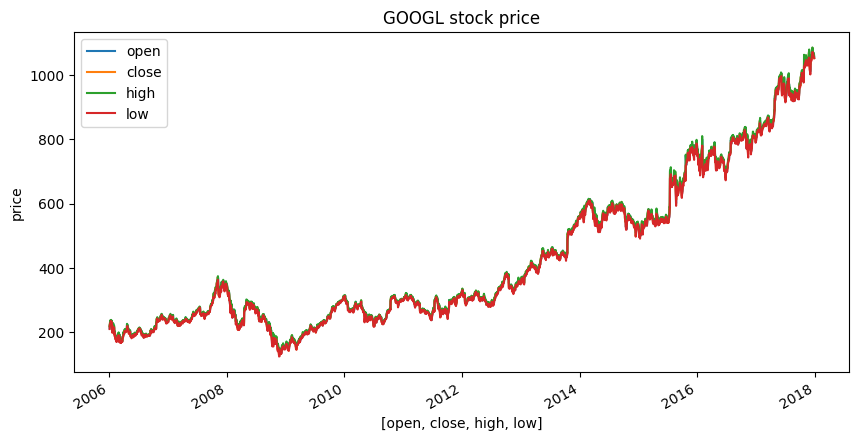

In [27]:
data.plot(x='date', y=['open', 'close', 'high', 'low'], title='GOOGL stock price', ylabel='price', xlabel=['open', 'close', 'high', 'low'], figsize=(10, 5))

Tiene sentido... vamos a analizar una ventana más corta

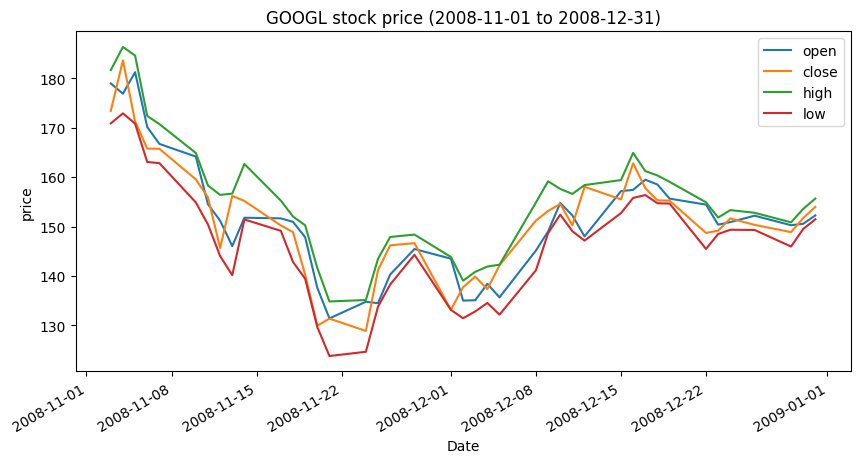

In [7]:
data['date'] = pd.to_datetime(data['date'])

# Filtrar los datos para una semana específica
start_date = '2008-11-01'  # Fecha de inicio de cierta ventana de tiempo
end_date = '2008-12-31'    # Fecha de fin de cierta ventana de tiempo
window = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Graficar los datos filtrados
window.plot(x='date', y=['open', 'close', 'high', 'low'], 
               title=f'GOOGL stock price ({start_date} to {end_date})',
               ylabel='price', xlabel='Date',
               figsize=(10, 5))

plt.show()

Construye un Dataset que reciba la compañía sobre la que se va a entrenar, el tamaño de ventana y de horizonte. Teniendo en cuenta que estamos ante una serie multivariable.

In [ ]:
class StocksDataset(torch.utils.data.Dataset):
    def __init__(self, df, w=10, h=1):
        ...

    def __len__(self):
        ...

    def __getitem__(self, t):
        features = ... # [i: i+w)
        target = ... # [i+w, i+w+h)
        return features, target

Para seguir, el siguiente código no debe dar error ninguno

In [9]:
w = 10
h = 3
input_size = len(['open', 'high', 'low', 'close'])

df = pd.read_csv(DATA_PATH)
dataset = StocksDataset(df, w=w, h=h)

sample = dataset[0]

assert len(sample) == 2 # Comprobamos que el dataset devuelve dos elementos
assert sample[0].shape == (w, input_size) # Comprobamos que las features tienen la forma correcta
assert sample[1].shape == (h,) # Comprobamos que el target tiene la forma correcta

Si hacemos MinMax el valor máximo del train (valores más tempranos temporalmente) será muy inferior a los valores máximos del test (futuro). Pudiendo pasar algo como esto:

![incorrect_norm_time_series](../../../utils/incorrect_norm_time_series.png)

Una forma de eliminar la tendencia (detrending) es con diferenciación temporal. A cada valor futuro le restaremos el anterior iterativamente.

<Axes: title={'center': 'GOOGL stock price'}, xlabel='[open, close, high, low]', ylabel='price'>

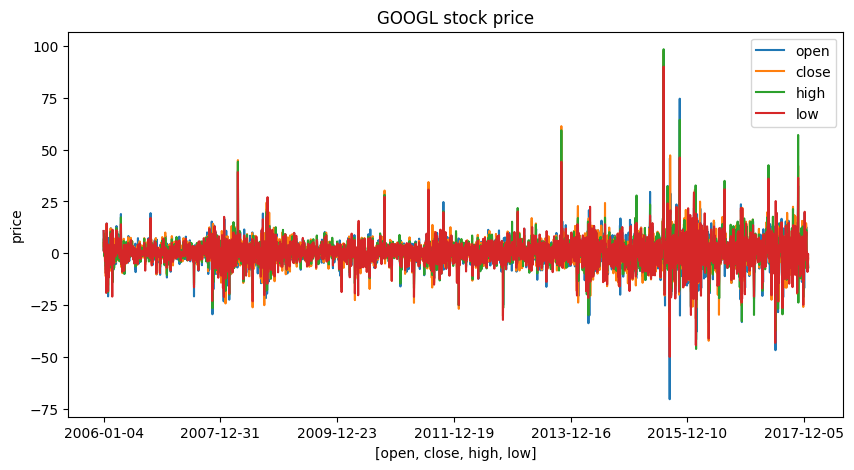

In [66]:
df = pd.read_csv(DATA_PATH)

def detrend(df):
    # Aplicar la diferenciación
    detrended_df = df.copy()
    detrended_df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].diff()

    detrended_df.dropna(inplace=True)
    return detrended_df

detrended_df = detrend(df)

# Graficar los datos detrended	
detrended_df.plot(x='date', y=['open', 'close', 'high', 'low'], title='GOOGL stock price', ylabel='price', xlabel=['open', 'close', 'high', 'low'], figsize=(10, 5))

Ya podemos crear el DataModule

In [ ]:
class StocksDataModule(pytorch_lightning.LightningDataModule):
    def __init__(self, df, w=10, h=1, batch_size=16, val_size=0.2, test_size=0.2):
        super().__init__()
        self.data = df

        self.detrend() # Aplicamos la diferenciación eliminando la tendencia
        self.sequential_train_val_test_split(val_size=val_size, test_size=test_size)
        self.normalize()

        self.w = w
        self.h = h

        self.batch_size = batch_size

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = StocksDataset(self.train_df, w=self.w, h=self.h)
            self.val_dataset = StocksDataset(self.val_df, w=self.w, h=self.h)
        elif stage == 'test':
            self.test_dataset = StocksDataset(self.test_df, w=self.w, h=self.h)

    def detrend(self):
        # Aplicar la diferenciación
        ...
        self.data = detrended_df

    def sequential_train_val_test_split(self, val_size=0.2, test_size=0.2):
        # Aseguramos el formato de la fecha y ordenamos por ella
        ...

        # Calculamos los índices para hacer los splits
        ...

        self.train_df = ...
        self.val_df = ...
        self.test_df = ...

    def normalize(self):
        # Ajustar el scaler solo con los datos del conjunto de entrenamiento de la columna 'close'
        ...

        # Escalar las diferencias de train, val y test
        ...

    def collate_fn(self, batch):
        ...
        return features, targets
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn=self.collate_fn)

A continuación, crearemos modelos de regresión temporal basados en LSTMs y GRUs. Buenas noticias, la sintáxis es idéntica a la de la RNN básica ya que a pesar de tener una arquitectura ligeramente diferente para la célula, siguen siendo redes recurrentes con las mismas dimensiones de entradas y salidas.

La diferencia con el que hemos aprendido en clase será que este reciba un argumento extra _pooling_[str] que podrá tomar tres valores y actuar en consecuencia:

- _pooling_ = "last" -> tomará la última salida de la RNN
- _pooling_ = "mean" -> realizará las medias a lo largo del eje temporal
- _pooling_ = "max" -> computará el máximo en la dimensión temporal

Sea cual sea la dimensión de salida no deberá variar

Además será un módulo altamente flexible que aceptará el parámetro _rnn_[str] que podrá tomar tres valores (rnn, lstm o gru) y en función de ello se instanciará en el init el modelo pertinente.

In [ ]:
STR2MODEL = {
    'rnn' : nn.RNN,
    'lstm': nn.LSTM,
    'gru' : nn.GRU
}

class TimeSeriesRegressor(nn.Module):
    """
    Time Series Regressor model
    rnn[str]: tipo de RNN a utilizar (rnn, lstm o gru)
    h[int]: horizonte de predicción
    input_size[int]: variables de la serie temporal
    hidden_size[int]: tamaño de las capas ocultas de la RNN
    num_layers[int]: número de capas de la RNN (si > 1, stacking de células RNN)
    batch_first[bool]: si el batch_size es la primera dimensión
    p_drop[float]: probabilidad de dropout
    pooling[str]: tipo de pooling a realizar sobre las salidas de la RNN
    """
    def __init__(self, rnn='rnn', h=1, input_size=1, hidden_size=64, num_layers=1, batch_first=True, p_drop=0.0, pooling='last'):
        super().__init__()
        ...
    
    def forward(self, x):
        ...

Creemos el LightningModule, muy similar a otros casos en los que hayamos realizado regresión.

Recibirá el modelo (model) con el nn.Module que vayamos a entrenar.


El único requisito es computar, aparte de la loss pertinente para regresión, la métrica MAPE o Mean Absolute Percentage Error.

In [ ]:
class StockPredictor(pytorch_lightning.LightningModule):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters() # guardamos la configuración de hiperparámetros
        ...

    def forward(self, x):
        ...
    
    def compute_batch(self, batch, split='train'):
        ...
        
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'val')
    
    def test_step(self, batch, batch_idx):
        return self.compute_batch(batch, 'test')
    
    def configure_optimizers(self):
        ...

A entrenar!

In [ ]:
# Parámetros
SAVE_DIR = f'lightning_logs/stocks/{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
rnn = 'gru'
w = 10
h = 1
input_size = len(['open', 'high', 'low', 'close'])
batch_size = 64
num_layers = 1
hidden_size = 128
learning_rate = 1e-3
p_drop = 0.2
pooling = 'last'

# DataModule
data = pd.read_csv(DATA_PATH)
data_module = StocksDataModule(data, w=w, h=h, batch_size=batch_size)

# Model 
model = TimeSeriesRegressor(rnn=rnn, h=h, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, p_drop=p_drop, pooling=pooling)

# LightningModule
module = StockPredictor(model, learning_rate=learning_rate)

# Callbacks
early_stopping_callback = pytorch_lightning.callbacks.EarlyStopping(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', 
    patience=5, # número de epochs sin mejora antes de parar
    verbose=False, # si queremos que muestre mensajes del estado del early stopping 
)
model_checkpoint_callback = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor='val_loss', # monitorizamos la pérdida en el conjunto de validación
    mode='min', # queremos minimizar la pérdida
    save_top_k=1, # guardamos solo el mejor modelo
    dirpath=SAVE_DIR, # directorio donde se guardan los modelos
    filename=f'best_model' # nombre del archivo
)

callbacks = [early_stopping_callback, model_checkpoint_callback]

# Loggers
csv_logger = pytorch_lightning.loggers.CSVLogger(
    save_dir=SAVE_DIR,
    name='metrics',
    version=None
)

loggers = [csv_logger] # se pueden poner varios loggers (mirar documentación)

# Trainer
trainer = pytorch_lightning.Trainer(max_epochs=50, accelerator='gpu', devices=[0], callbacks=callbacks, logger=loggers)

trainer.fit(module, data_module)
results = trainer.test(module, data_module)

# EXTRA: From Scratch LSTM & GRU

In [26]:
STR2ACT = {
    'tanh' : nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'relu' : nn.ReLU,
    'gelu' : nn.GELU
}
    
class LSTM(nn.Module):
    """
    I_t (input_gate): how much of the input is added to the internal state
    F_t (forget_gate): whether to keep the current memory state or flush it
    O_t (output_gate): wheter the memory cell should influence the output
    C_t (cell_gate): how much we take into account new data
    """
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.layers = [self.lstm_layer(input_layer=(l==0))for l in range(num_layers)]

        self.sigmoid = nn.Sigmoid() 
        self.tanh = nn.Tanh()
        
    def lstm_layer(self, input_layer=False):
        """
        self.hidden_size * 4 because we use the same linear layer for
        the four gates and then split the outputs
        """
        return nn.ModuleDict({
            'w_ih': nn.Linear(self.input_size if input_layer else self.hidden_size, self.hidden_size * 4, bias=False),
            'w_hh': nn.Linear(self.hidden_size, self.hidden_size * 4),
        })

    def forward(self, x, h=None):
        """
        In deep LSTMs (num_layers > 1), hidden and internal state are propagated as:
        - h(t, l) -> h(t+1, l); h(t, l) -> h(t, l+1)
        - c(t, l) -> c(t+1, l); c(t, l) -> c(t, l+1)
        """
        x = x.transpose(0, 1) # [batch_size, seq_len, input_size] -> [seq_len, batch_size, input_size]
        seq_len, batch_size, _ = x.size()

        if h is None: # by default, hidden and internal states are initialized to 0s
            h = x.new_zeros((self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x

        h, c = (h, h) # at first, internal state is a copy of the hidden state

        output = []
        for t in range(seq_len):
            x_t = x[t]
            for l, layer in enumerate(self.layers):
                gates_proj = layer['w_ih'](x_t) + layer['w_hh'](h[l]) # [batch_size, hidden_size * 4]
                input_gate, forget_gate, output_gate, cell_gate = gates_proj.chunk(4, dim=1)

                input_gate = self.sigmoid(input_gate)
                forget_gate = self.sigmoid(forget_gate)
                output_gate = self.sigmoid(output_gate)
                cell_gate = self.tanh(cell_gate)

                c[l] = c[l] * forget_gate + input_gate * cell_gate
                h[l] = self.tanh(c[l]) * output_gate
                x_t = h[l]

            output.append(h[-1])

        return torch.stack(output).transpose(0, 1) # [seq_len, batch_size, hidden_size] -> [batch_size, seq_len, hidden_size]
        
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.layers = nn.ModuleList([self.gru_layer(input_layer=(i==0)) for i in range(num_layers)])

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def gru_layer(self, input_layer=False):
        """
        self.hidden_size * 2 because we use the same linear layer for
        computing the reset and update gate

        w_ch is the linear layer for computing the candidate hidden state
        """
        return nn.ModuleDict({
            'w_ig': nn.Linear(self.input_size if input_layer else self.hidden_size, self.hidden_size * 2, bias=False), # input to reset and update gates
            'w_hg': nn.Linear(self.hidden_size, self.hidden_size * 2), # hidden state to reset and update gates
            'w_ih': nn.Linear(self.input_size if input_layer else self.hidden_size, self.hidden_size, bias=False), # input to candidate hidden state
            'w_gh': nn.Linear(self.hidden_size, self.hidden_size) # reset gate * hidden state to candidate hidden state
        })
    
    def forward(self, x, h=None):
        x = x.transpose(0, 1) # [batch_size, seq_len, input_size] -> [seq_len, batch_size, input_size]
        seq_len, batch_size, _ = x.size()

        if h is None: # by default, hidden and internal states are initialized to 0s
            h = x.new_zeros((self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x

        output = []

        for t in range(seq_len):
            x_t = x[t]
            for l, layer in enumerate(self.layers):
                gates_proj = layer['w_ig'](x_t) + layer['w_hg'](h[l])
                reset_gate, update_gate = gates_proj.chunk(2, dim=1)

                reset_gate = self.sigmoid(reset_gate)
                update_gate = self.sigmoid(update_gate)

                candidate_hidden_state = layer['w_gh'](reset_gate * h[l]) + layer['w_ih'](x_t)
                candidate_hidden_state = self.tanh(candidate_hidden_state)

                h[l] = ((1 - update_gate) * candidate_hidden_state) + (h[l] * update_gate)

                x_t = h[l]
            
            output.append(h[-1])

        return torch.stack(output).transpose(0, 1) # [seq_len, batch_size, hidden_size] -> [batch_size, seq_len, hidden_size]

In [29]:
input_size = 3
hidden_size = 128
num_layers = 3

batch_size = 2
seq_len = 10


model = LSTM(input_size, hidden_size, num_layers=num_layers)

x = torch.randn(batch_size, seq_len, input_size)

x.size(), model(x).size()

(torch.Size([2, 10, 3]), torch.Size([2, 10, 128]))

# Bidirectional RNN
La misma lógica es extrapolable a LSTMs o GRUs

In [ ]:
class RNN(nn.Module):
    """
    Implementation of a Recurrent Neural Network

    __init__()
    input_size[int]: features per timestep, if > 1 is multivariate
    hidden_size[int]: hidden size, normally between (64, 2056)
    num_layers[int]: number of rnn stacked cells, if > 1 is DeepRNN, normally between (1, 8)
    bidirectional[bool]: if the rnn is bidirectional
    bias[bool]: if input linear layers have bias

    forward()
    x[torch.Tensor]: model input of size [batch_size, seq_len, input_size]
    h[torch.Tensor]: initial hidden state of size [batch_size, seq_len, input_size], if None it will be zeros
    """
    def __init__(self, input_size, hidden_size, num_layers=1, bidirectional=False, bias=False, activation='tanh', p_drop=0.0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.bias = bias
        self.p_drop = p_drop

        self.l2r = nn.ModuleList([self.rnn_layer(input_layer=(l==0)) for l in range(self.num_layers)]) # left to right RNN

        if bidirectional:
            self.r2l = nn.ModuleList([self.rnn_layer(input_layer=(l==0)) for l in range(self.num_layers)]) # right to left RNN

        self.activation = STR2ACT[activation]() # tanh by default


    def rnn_layer(self, input_layer=False):
        return nn.ModuleDict({
            'w_ih' : nn.Linear(self.input_size if input_layer else self.hidden_size, self.hidden_size, bias=self.bias),
            'w_hh' : nn.Linear(self.hidden_size, self.hidden_size),
            'drop' : nn.Dropout(self.p_drop)
        })
    
    def process_sequence(self, x, h, direction='l2r'):
        """
        In deep RNNs (num_layers > 1), hidden state is propagated as:
        - input hidden state of the next layer of the current timestep; h(l, t) -> h(l+1, t)
        - input hidden state of the current layer of the next timestep; h(l, t) -> h(l, t+1)
        """
        seq_len = x.size(0)
        layers = self.l2r if direction == 'l2r' else self.r2l

        output = []
        for t in range(seq_len):
            x_t = x[t] # input
            for l, layer in enumerate(layers):
                # h[l] here is the lth hidden state for t-1
                # when override it will be the lth hidden state for t
                h[l] = self.activation(
                    layer['w_ih'](x_t) + layer['w_hh'](h[l])
                )
                h[l] = layer['drop'](h[l]) # no dropout by default

                x_t = h[l] # also, it will be the input for the l+1th layer of t
            
            output.append(h[-1]) # final hidden state for timestep t
        
        return torch.stack(output).transpose(0, 1) # [seq_len, batch_size, hidden_size] -> [batch_size, seq_len, hidden_size]

    def forward(self, x, h=None):
        x = x.transpose(0, 1) # [batch_size, seq_len, input_size] -> [seq_len, batch_size, input_size]
        batch_size = x.size(1)

        if self.bidirectional:
            if h is None: # by default, hidden state is initialized to 0s
                h = x.new_zeros((2, self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x
            
            h_l2r, h_r2l = h[0], h[1] # if h is passed in bidirectional it is assumed that the format is [2, num_layers, batch_size, hidden_size]
            
            l2r_output = self.process_sequence(x, h_l2r, direction='l2r')
            r2l_output = self.process_sequence(x.flip(dims=[-1]), h_r2l, direction='r2l')

            r2l_output = r2l_output.flip(dims=[-1]) # flip to get left to right context

            output = torch.cat([l2r_output, r2l_output], dim=-1) # [batch_size, seq_len, 2 * hidden_size]

        else:
            if h is None: # by default, hidden state is initialized to 0s
                h = x.new_zeros((self.num_layers, batch_size, self.hidden_size)) # same device and dtype as x
            
            output = self.process_sequence(x, h, direction='l2r') # [batch_size, seq_len, hidden_size]
        
        return output